<a href="https://colab.research.google.com/github/iojoseg/Desarrollo_aplicaciones_moviles/blob/master/%5B2020%5D_DevFestM%C3%A9xico_Machine_Learning_Pr%C3%A1ctico(Style_Transfer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Style Transfer
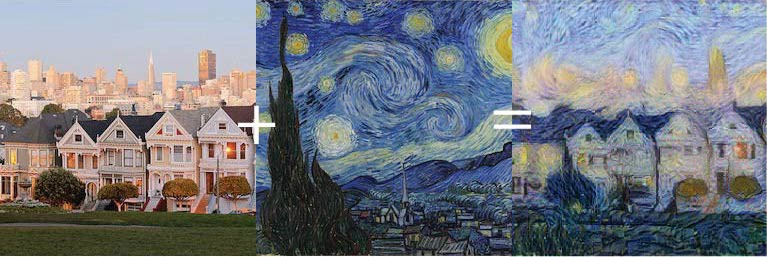

##Motivación

Durante los últimos años, las ConvNets (CNNs o Redes Neuronales Convolucionales) son la herramienta *por defecto* para trabajar con imágenes en Deep Learning.

En el 2015, a través de un [paper](https://arxiv.org/abs/1508.06576), los autores propusieron que las CNNs pueden distinguir entre estilo y contenido.

Realizado una función de loss para cada caso (contenido y estilo), demostraron que usando CNNs puede combinarse contenido de una imagen con estilo de otra para crear una nueva.

Algo sorprendente de este proceso, es que no es necesario entrenar al modelo, pesos de un modelo previamente entrenado funcionan muy bien.

**Cómo podemos implementarlo?**

1.   Generar una imagen a partir de la imagen de contenido.
2.   Pasarla a través de una arquitectura previamente entrenada (como VGG, ResNet, etc). Notar que este modelo **NO** será entrenado durante backpropagation. Se utilizará para identificar contenido y estilo.
3.   Calcular loss y computar los gradientes. Solo los pixeles del input se ajustan, los pesos se mantienen constantes.


##Usando Transferencia de Estilo

In [ ]:
import tensorflow as tf
import numpy as np

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
tf.__version__

'2.3.0'

####Funciones de apoyo

In [ ]:
import PIL.Image as Image
import matplotlib.pyplot as plt 
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'}) #dark theme

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = np.squeeze(image, axis=0)
  if title:
    plt.title(title)

  plt.imshow(image)
  plt.axis('off')

def load_img(path):
  img = Image.open(path)
  max_size = 256
  ratio = min(max_size/img.width, max_size/img.height)
  size = (round(img.width*ratio), round(img.height*ratio))
  img = img.resize(size)

  img = np.array(img).astype(np.float32)/255.
  return img[np.newaxis, :]

####Datos de entrada

In [ ]:
from tensorflow.keras.utils import get_file

content_url = get_file('toby.jpg', 'https://pbs.twimg.com/media/EkdsEULXgAQjcQM?format=jpg')
style_url = get_file('merida.jpg','https://cdn.local.mx/wp-content/uploads/2018/11/destacada-carlos_merida.jpg')

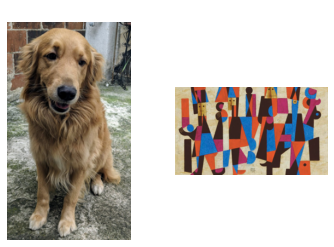

In [ ]:
content_img = load_img(content_url)
style_img = load_img(style_url)

plt.subplot(1, 2, 1)
imshow(content_img, 'content')

plt.subplot(1, 2, 2)
imshow(style_img, 'style')

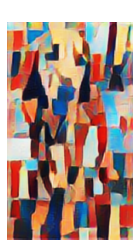

In [ ]:
import tensorflow_hub as hub

hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_img = hub_module(tf.constant(content_img), tf.constant(style_img))[0]

imshow(stylized_img.numpy(), 'stylized')

##Construyendo un modelo de transferencia de estilo

Puede separarse en dos problemas


1.   generar contenido (con base en input A)
2.   generar estilo (con base en input B)

Para resolver el primero, utilizamos feature maps convolucionales, estos capturan información espacial sin interesarse por el estilo. Por ejemplo si tenemos un golden retriever, queremos conservar su cara, orejas y que sea reconocible como un perro.

Para resolver el segundo, se extrae el estilo utilizando otras capas convolucionales y se utiliza la matriz de Gram. Mientras más alta la capa, el receptive field es mayor y esto permite identificar características mayor escala(estilo). Para estilo, múltiples capas deberían ser utilizadas, para incorporar características locales y globales de la imagen.

En ambos casos, se utilizan capas de un modelo previamente entrenado, en este caso, será VGG-19.



####Usando VGG

In [ ]:
from tensorflow.keras.applications import VGG19, vgg19

vgg = VGG19(include_top=True, weights='imagenet')
x = vgg19.preprocess_input(content_img*255)
x = tf.image.resize(x, (224, 224))
model_prediction = vgg(x)

predictions = vgg19.decode_predictions(model_prediction.numpy())[0]
predictions

[('n02099601', 'golden_retriever', 0.68634266),
 ('n04409515', 'tennis_ball', 0.028213982),
 ('n04254680', 'soccer_ball', 0.027758304),
 ('n02099712', 'Labrador_retriever', 0.022905843),
 ('n02108551', 'Tibetan_mastiff', 0.01740634)]

Arquitectura VGG-19
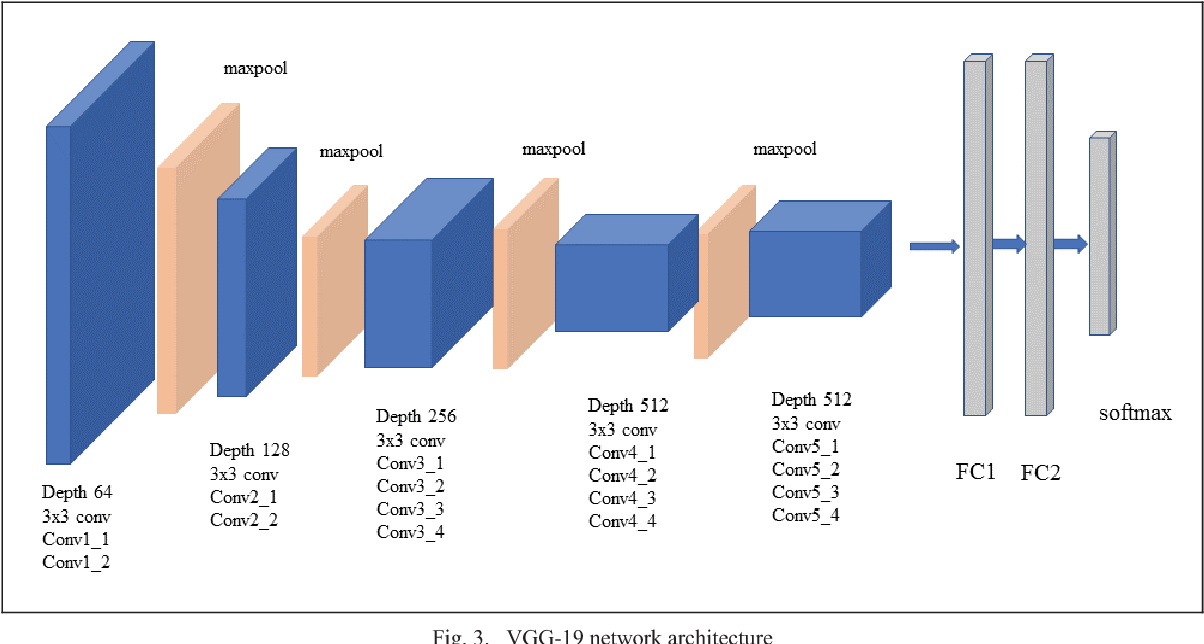

In [ ]:
for layer in vgg.layers:
  print(layer.name)

input_11
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv4'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [ ]:
from tensorflow.keras.models import Model

vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

vgg_model = Model([vgg.input], 
                  [vgg.get_layer(name).output for name in (style_layers+content_layers)])

vgg_model.trainable = False

###Loss

In [ ]:
def compute_loss (outputs, targets, num_layers):
  style_loss = tf.add_n([tf.reduce_mean((outputs['style'][name]-targets['style'][name])**2) 
                          for name in outputs['style'].keys()]) 
  
  content_loss = tf.add_n([tf.reduce_mean((outputs['content'][name]-targets['content'][name])**2) 
                            for name in outputs['content'].keys()])
  
  style_weight = 1e-1
  content_weight = 1e2
  style_loss *= style_weight / num_layers['style']
  content_loss *= content_weight / num_layers['content']

  return style_loss + content_loss

### Detectando estilo y contenido

Antes de hablar de la matriz de Gram, es necesario mencionar el producto punto.

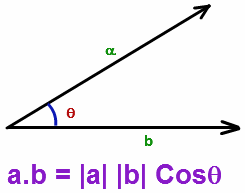

El producto punto de dos vectores es la suma de los productos de sus respectivas coordenadas. Puede ser visto como "qué tan parecidos son dos vectores", mientras mayor similud, menor será el ángulo entre ellos o más cercanas serán sus coordenadas. En ambos casos, el resultado es un número grande, es decir, mientras mayor similitud, mayor será el producto punto.

**Qué tiene esto que ver con Redes Neuronales?**

Si tomamos dos vectores aplanados de un feature map convolucional, representando características de una imagen, el producto punto nos da información al respecto. Mientras más pequeño, hay mayor diferencia y mientras más grande, existe mayor correlación. De aquí obtenemos mucha información de estilo (textura) pero nada de su estructura espacial.

Si aplicamos esta idea a todos los vectores de un feature map convolucional, obtenemos la matriz de Gram.


In [ ]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

In [ ]:
class StyleContentModel(Model):
  def __init__(self, vgg_model, content_layers, style_layers):
    super(StyleContentModel, self).__init__()

    self.vgg =  vgg_model
    self.style_layers = style_layers
    self.content_layers = content_layers
    
  def call(self, inputs):
    preprocessed_input = vgg19.preprocess_input(inputs*255.0)
    outputs = self.vgg(preprocessed_input)
    
    style_outputs, content_outputs = (outputs[:len(self.style_layers) ], 
                                      outputs[len(self.style_layers) :])
    
    style_outputs = [gram_matrix(style_output)
                      for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

## Training

Vamos a utilizar un algoritmo de optimización basado en SGD (Adam en este caso), pero en vez de optimizar los parámetros, optimizamos los valores de los pixeles de la imagen resultante.

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

extractor = StyleContentModel(vgg_model, content_layers, style_layers)
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

targets = {'content':content_targets, 
           'style':style_targets}

num_layers = {'content': len(content_layers), 
              'style': len(style_layers)}

def train_step(input_image):
  with tf.GradientTape() as tape:
    prediction = extractor(input_image)

    loss = compute_loss(prediction, targets, num_layers)

  grad = tape.gradient(loss, input_image)
  opt.apply_gradients([(grad, input_image)])

  input_image.assign(tf.clip_by_value(input_image, 0.0, 1.0))

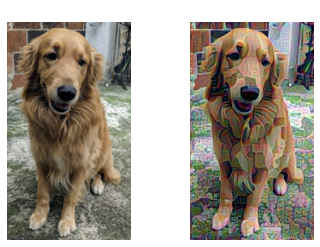

In [ ]:
image = tf.Variable(content_img)

plt.subplot(1, 2, 1)
imshow(image.numpy(), 'before')

train_step(image)
train_step(image)
train_step(image)

plt.subplot(1, 2, 2)
imshow(image.numpy(), 'after')

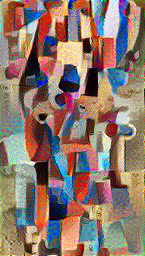

step:2000


In [ ]:
import IPython.display as display

epochs = 20
steps_per_epoch = 100

image = tf.Variable(content_img)

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".",end='')

  as_img = Image.fromarray(np.squeeze(
                      (image.numpy()*255)
                              .astype(np.uint8)
                      )
                )
  display.clear_output(wait=True)
  display.display(as_img)
  print(f'step:{step}')